In [1]:
! pip install --upgrade --user git+https://github.com/asford/gcsfs.git@per_dir_cache

  Cloning https://github.com/asford/gcsfs.git (to per_dir_cache) to /tmp/pip-i8di8inn-build
Requirement already up-to-date: google-auth>=1.2 in /opt/conda/lib/python3.6/site-packages (from gcsfs==0.0.4)
Requirement already up-to-date: google-auth-oauthlib in /opt/conda/lib/python3.6/site-packages (from gcsfs==0.0.4)
Requirement already up-to-date: requests in /opt/conda/lib/python3.6/site-packages (from gcsfs==0.0.4)
Requirement already up-to-date: decorator in /home/jovyan/.local/lib/python3.6/site-packages (from gcsfs==0.0.4)
Requirement already up-to-date: rsa>=3.1.4 in /opt/conda/lib/python3.6/site-packages (from google-auth>=1.2->gcsfs==0.0.4)
Requirement already up-to-date: pyasn1-modules>=0.2.1 in /opt/conda/lib/python3.6/site-packages (from google-auth>=1.2->gcsfs==0.0.4)
Requirement already up-to-date: six>=1.9.0 in /opt/conda/lib/python3.6/site-packages (from google-auth>=1.2->gcsfs==0.0.4)
Requirement already up-to-date: cachetools>=2.0.0 in /opt/conda/lib/python3.6/site-pac

In [5]:
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import gcsfs

### Connect to Dask Distributed Cluster

In [2]:
from dask.distributed import Client, progress

from daskernetes import KubeCluster
cluster = KubeCluster(n_workers=20, 
                      env={'EXTRA_PIP_PACKAGES': '--upgrade git+https://github.com/asford/gcsfs.git@per_dir_cache'})
cluster

VBox(children=(HTML(value='<b>Dashboard:</b> <a href="/user/rabernat/proxy/8787/status" target="_blank">/user/rabernat/proxy/8787/status</a>'), IntText(value=0, description='Requested', layout=Layout(width='150px')), Text(value='0', description='Actual', layout=Layout(width='150px')), Button(description='Scale', layout=Layout(width='150px'), style=ButtonStyle())))

In [3]:
client = Client(cluster)
client

Client Scheduler: tcp://10.20.158.13:35256 Dashboard: http://10.20.158.13:8787/status,Cluster Workers: 17 Cores: 34 Memory: 119.00 GB


In [2]:
def turn_on_gcsfs_logging():
    import logging
    logging.basicConfig(
        format="%(created)0.3f %(levelname)s %(name)s %(message)s",
        level=logging.INFO)
    logging.getLogger("gcsfs.core").setLevel(logging.DEBUG)
    logging.getLogger("gcsfs.gcsfs").setLevel(logging.DEBUG)

In [7]:
#turn_on_gcsfs_logging()
#res = client.run(turn_on_gcsfs_logging)

In [6]:
import gcsfs
gcs = gcsfs.GCSFileSystem() # (token='cloud') # that doesn't work with experimental branch
gcsmap = gcsfs.mapping.GCSMap('pangeo-data/dataset-duacs-rep-global-merged-allsat-phy-l4-v3-alt',
                              gcs=gcs)
%time ds = xr.open_zarr(gcsmap)
ds

CPU times: user 1.54 s, sys: 252 ms, total: 1.79 s
Wall time: 7.79 s


<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 8901)
Coordinates:
    crs        int32 ...
    lat_bnds   (time, latitude, nv) float32 dask.array<shape=(8901, 720, 2), chunksize=(5, 720, 2)>
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 -89.125 -88.875 ...
    lon_bnds   (longitude, nv) float32 dask.array<shape=(1440, 2), chunksize=(1440, 2)>
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 ...
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 1993-01-03 ...
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<shape=(8901, 720, 1440), chunksize=(5, 720, 1440)>
    err        (time, latitude, longitude) float64 dask.array<shape=(8901, 720, 1440), chunksize=(5, 720, 1440)>
    sla        (time, latitude, longitude) float64 dask.array<shape=(8901, 720, 1440), chunksize=(5, 720, 1440)>
    ugos       (time, latitude, longitude) float64 dask.array<shape=(890

In [ ]:
ds.nbytes / 1e9

In [7]:
sla_timeseries = ds.sla.mean(dim=('latitude', 'longitude')).persist()

In [ ]:
sla_timeseries.plot()

In [9]:
sla_hov = ds.sla.mean(dim='longitude').persist()

tornado.application - ERROR - Exception in callback <bound method WorkStealing.balance of <distributed.stealing.WorkStealing object at 0x7f8b258aca20>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 1026, in _run
    return self.callback()
  File "/opt/conda/lib/python3.6/site-packages/distributed/stealing.py", line 332, in balance
    stealable.remove(ts)
KeyError: <Task "('mean_chunk-mean_agg-aggregate-4be8a87fd17c9b5990d454e8e451a4e3', 1503, 0)" memory>
tornado.application - ERROR - Exception in callback <bound method WorkStealing.balance of <distributed.stealing.WorkStealing object at 0x7f8b258aca20>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 1026, in _run
    return self.callback()
  File "/opt/conda/lib/python3.6/site-packages/distributed/stealing.py", line 332, in balance
    stealable.remove(ts)
KeyError: <Task "('mean_chunk-mean_agg-aggregate-4be8a87fd17

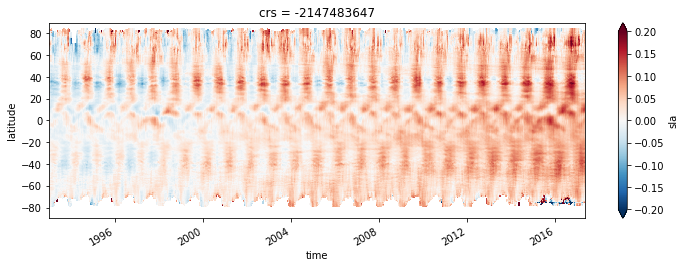

In [10]:
fig, ax = plt.subplots(figsize=(12,4))
sla_hov.transpose().plot(vmax=0.2, ax=ax)


In [20]:
del sla_hov

In [8]:
all_timeseries = ds.mean(dim=('latitude', 'longitude')).persist()

tornado.application - ERROR - Exception in callback <bound method WorkStealing.balance of <distributed.stealing.WorkStealing object at 0x7f8b258aca20>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 1026, in _run
    return self.callback()
  File "/opt/conda/lib/python3.6/site-packages/distributed/stealing.py", line 332, in balance
    stealable.remove(ts)
KeyError: <Task "('zarr-sla-b3049edf2944064ba880e2c70ca4e4da', 1073, 0, 0)" memory>
tornado.application - ERROR - Exception in callback <bound method WorkStealing.balance of <distributed.stealing.WorkStealing object at 0x7f8b258aca20>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 1026, in _run
    return self.callback()
  File "/opt/conda/lib/python3.6/site-packages/distributed/stealing.py", line 332, in balance
    stealable.remove(ts)
KeyError: <Task "('zarr-vgos-14fdfb044014fdce09883a45d345edce', 1572, 0, 0)" m

In [11]:
del all_timeseries

In [ ]:
sla_timeseries = ds.sla.mean(dim=('latitude', 'longitude')).load()

In [ ]:
ds.mean().persist()

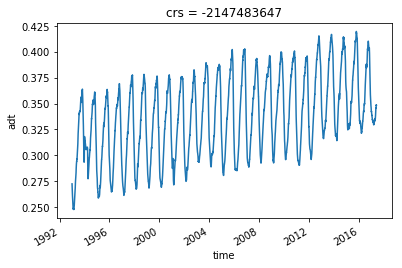

In [30]:
adt_timeseries.plot()

In [12]:
ds_mm = ds.groupby('time.month').mean(dim='time')
ds_mm

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, month: 12, nv: 2)
Coordinates:
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 -89.125 -88.875 ...
    lon_bnds   (longitude, nv) float32 0.0 0.25 0.25 0.5 0.5 0.75 0.75 1.0 ...
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 ...
  * nv         (nv) int32 0 1
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    adt        (month, latitude, longitude) float64 dask.array<shape=(12, 720, 1440), chunksize=(1, 720, 1440)>
    err        (month, latitude, longitude) float64 dask.array<shape=(12, 720, 1440), chunksize=(1, 720, 1440)>
    sla        (month, latitude, longitude) float64 dask.array<shape=(12, 720, 1440), chunksize=(1, 720, 1440)>
    ugos       (month, latitude, longitude) float64 dask.array<shape=(12, 720, 1440), chunksize=(1, 720, 1440)>
    ugosa      (month, latitude, longitude) float64 dask.array<shape=(12, 720, 1440), chunksize=(1, 720, 1440)>
    

In [10]:
ds_mm.nbytes /1e9

0.696749864

In [13]:
ds_mm_p = ds_mm.persist()

tornado.application - ERROR - Exception in callback <bound method WorkStealing.balance of <distributed.stealing.WorkStealing object at 0x7f8b258aca20>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 1026, in _run
    return self.callback()
  File "/opt/conda/lib/python3.6/site-packages/distributed/stealing.py", line 332, in balance
    stealable.remove(ts)
KeyError: <Task "('zarr-sla-b3049edf2944064ba880e2c70ca4e4da', 36, 0, 0)" memory>
tornado.application - ERROR - Exception in callback <bound method WorkStealing.balance of <distributed.stealing.WorkStealing object at 0x7f8b258aca20>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 1026, in _run
    return self.callback()
  File "/opt/conda/lib/python3.6/site-packages/distributed/stealing.py", line 332, in balance
    stealable.remove(ts)
KeyError: <Task "('zarr-sla-b3049edf2944064ba880e2c70ca4e4da', 1777, 0, 0)" memo

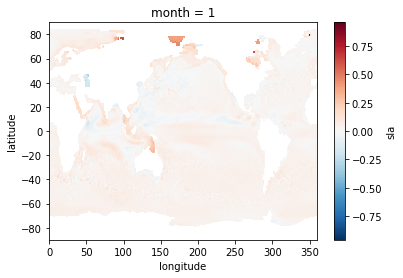

In [14]:
ds_mm_p.sla[0].plot()

In [16]:
sla_anom = ds.sla.groupby('time.month') - ds_mm_p.sla
sla_anom

<xarray.DataArray 'sla' (time: 8901, latitude: 720, longitude: 1440)>
dask.array<shape=(8901, 720, 1440), dtype=float64, chunksize=(8901, 720, 1440)>
Coordinates:
    crs        int32 ...
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 -89.125 -88.875 ...
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 ...
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 1993-01-03 ...
    month      (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...

In [ ]:
sla_anom_ts = sla_anom.mean(dim=('longitude', 'latitude')).persist()

In [ ]:
1 + 1